# Title

## Introduction

In [16]:
'''
All the imports for the project
'''

# Basic imports 
import json     # parse json objects
import re       # text clean up
import os       # system checks

# Data processing
import pandas as pd
import numpy as np

# Embeddings
import torch
from sentence_transformers import SentenceTransformer       # text -> vector embeddings

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score        # cluster accuracy evaluation
from sklearn.feature_extraction.text import TfidfVectorizer     # find keywords

# Visuals
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE       # reduce dimensionality visually

In [2]:
# Read data
path = "Electronics.jsonl"
reviews = []
max_rows = 1000000       # take first 1m reviews

# Open jsonl file and add each line (review) to reviews list
with open(path, "r") as f:
    for i, line in enumerate(f):
        if i >= max_rows:
            break
        reviews.append(json.loads(line))

# Convert to DF
df = pd.DataFrame(reviews)

# Display info
df.shape, df.info(), df[["rating", "title", "text"]].head(10)
df["rating"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   rating             1000000 non-null  float64
 1   title              1000000 non-null  object 
 2   text               1000000 non-null  object 
 3   images             1000000 non-null  object 
 4   asin               1000000 non-null  object 
 5   parent_asin        1000000 non-null  object 
 6   user_id            1000000 non-null  object 
 7   timestamp          1000000 non-null  int64  
 8   helpful_vote       1000000 non-null  int64  
 9   verified_purchase  1000000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 69.6+ MB


rating
5.0    649913
4.0    141739
1.0     89031
3.0     71612
2.0     47705
Name: count, dtype: int64

In [3]:
# Choose same number of reviews per rating
groups = df.groupby("rating")
balanced = []

for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    group = groups.get_group(rating)
    balanced.append(group.sample(20000, random_state=42)) # Take 20k reviews from each rating

balanced_df = pd.concat(balanced).reset_index(drop=True)

balanced_df["rating"].value_counts()

rating
1.0    20000
2.0    20000
3.0    20000
4.0    20000
5.0    20000
Name: count, dtype: int64

In [4]:
# Process data

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()                         # lower case
    text = re.sub(r"[^a-z0-9\s]", " ", text)    # keep letters, numbers, and spaces
    text = re.sub(r"\s+", " ", text).strip()    # remove extra spaces
    return text

# Create new column with cleaned text
balanced_df["cleaned_text"] = balanced_df["text"].apply(clean_text)

# Remove faulty text after cleaning
balanced_df = balanced_df[balanced_df["cleaned_text"].str.len() > 0].reset_index(drop=True)

# Create ground truth labels
def rating_to_sentiment(r):
    if r <= 2:
        return 0   # negative
    elif r == 3:
        return 1   # neutral
    else:
        return 2   # positive

balanced_df["sentiment_true"] = balanced_df["rating"].apply(rating_to_sentiment)


balanced_df[["text", "cleaned_text"]].head(10)

,text,cleaned_text
0,Cheap looking. Looks like something you get a...,cheap looking looks like something you get at ...
1,"I would look for another product, to provide y...",i would look for another product to provide yo...
2,Lids are very loose,lids are very loose
3,Do not buy this. After a couple of months of u...,do not buy this after a couple of months of us...
4,I'm a big TomTom fan and recommend them to man...,i m a big tomtom fan and recommend them to man...
5,didnt work,didnt work
6,"This unit sucks, had to return it cause you ca...",this unit sucks had to return it cause you can...
7,It has one function and doesn't perform that f...,it has one function and doesn t perform that f...
8,Garbage has static feedback,garbage has static feedback
9,"These Panasonic earbuds work fairly well, but ...",these panasonic earbuds work fairly well but d...


In [22]:
# Create vector embeddings from cleaned text

# Use pretrained light model
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

texts = balanced_df["cleaned_text"].tolist()
embeddings = model.encode(texts, batch_size=64, device=device, show_progress_bar=True)

Batches:   0%|          | 0/1562 [00:00<?, ?it/s]

In [23]:
# Cluster using k means

# Expected 3 groups: positive, neutral, and negative
k = 3

# Run k means and store labels
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(embeddings)
balanced_df["cluster"] = kmeans_labels
balanced_df[["rating", "cleaned_text", "cluster"]].head(10)

,rating,cleaned_text,cluster
0,1.0,cheap looking looks like something you get at ...,2
1,1.0,i would look for another product to provide yo...,2
2,1.0,lids are very loose,1
3,1.0,do not buy this after a couple of months of us...,0
4,1.0,i m a big tomtom fan and recommend them to man...,0
5,1.0,didnt work,0
6,1.0,this unit sucks had to return it cause you can...,0
7,1.0,it has one function and doesn t perform that f...,0
8,1.0,garbage has static feedback,0
9,1.0,these panasonic earbuds work fairly well but d...,1


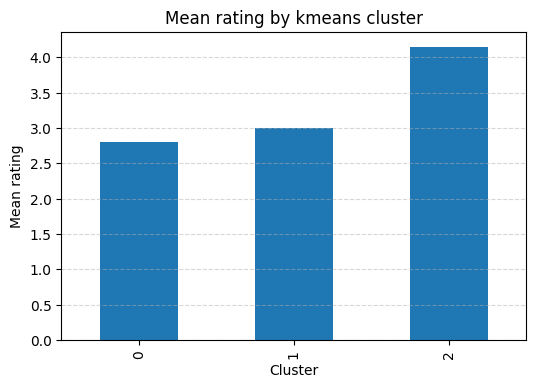

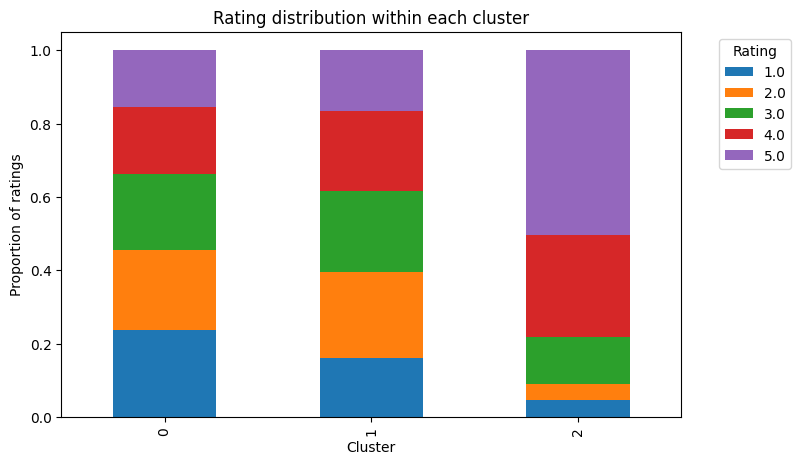

In [24]:
# Visualize k means

cluster_means = balanced_df.groupby("cluster")["rating"].mean()

plt.figure(figsize=(6,4))
cluster_means.plot(kind="bar")
plt.ylabel("Mean rating")
plt.xlabel("Cluster")
plt.title("Mean rating by kmeans cluster")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


rating_dist = pd.crosstab(balanced_df["cluster"], balanced_df["rating"], normalize="index")

rating_dist.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Proportion of ratings")
plt.xlabel("Cluster")
plt.title("Rating distribution within each cluster")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()



In [25]:
# KMeans NMI
nmi_kmeans = normalized_mutual_info_score(balanced_df["sentiment_true"], balanced_df["cluster"])
print("NMI: ", nmi_kmeans)

NMI:  0.05113444533724025


In [28]:
# TFIDF to find keywords

# Fit vectorizer 
tfidf = TfidfVectorizer(max_features=5000, min_df=5) # review x word matrix where entries are tfidf (importance) scores
X = tfidf.fit_transform(texts)
vocab = np.array(tfidf.get_feature_names_out())

# Find top n keywords per cluster
top_n = 10
for cluster in sorted(balanced_df["cluster"].unique()):
    mask = balanced_df["cluster"] == cluster # vector identifying which reviews are in cluster
    X_cluster = X[mask.to_numpy()] # only include reviews in cluster
    
    # Calculate average tfidf score per word in cluster and sort descending
    mean_tfidf = X_cluster.mean(axis=0)
    mean_tfidf = np.asarray(mean_tfidf).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:top_n]
    top_words = vocab[top_idx]

    # Display
    print(f"\nCluster {cluster} top words:")
    print(", ".join(top_words))


Cluster 0 top words:
the, it, to, and, is, br, this, for, not, of

Cluster 1 top words:
the, sound, to, and, it, is, br, for, my, they

Cluster 2 top words:
great, good, works, it, product, ok, as, love, very, well


Interpretation:
Cluster 2 accurately found positive reviews and it is reflected by the keywords using tfidf, but the other clusters did not have these distinctive words found in cluster 2. One possibility is that neutral and negative semantics do not usually come from individual words that are negative or neutral (people do not usually leave negative reviews by simply saying "it was bad")